# Load data images from disk

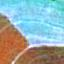

In [1]:
import os
from keras.preprocessing import image

base_dir = '/tf/data'

# Directories for training and test splits
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#Directory with training coffee pictures
train_coffee_dir = os.path.join(train_dir, 'coffee')
# Directory with training noncoffee pictures
train_noncoffee_dir = os.path.join(train_dir, 'noncoffee')

# Directory with test coffee pictures
test_coffee_dir = os.path.join(test_dir, 'coffee')
# Directory with test noncoffee pictures
test_noncoffee_dir = os.path.join(test_dir, 'noncoffee')


img = image.load_img(os.path.join(train_coffee_dir, 
                os.listdir(train_coffee_dir)[3]))

img.show()    # To show the image

### Tensorflow imports

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

# To calculate the confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix

From the 2nd edition of the book "Deep Learning with Python", chapter 8 - Instantiating a small convnet for dogs vs. cats classification

## Data augmentation layer

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Feature extraction

In [4]:
# conv_base = keras.applications.VGG16(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(img.size[0], img.size[1], 3))

In [5]:
# conv_base = keras.applications.efficientnet.EfficientNetB0(
#     weights="imagenet",
#     include_top=False,
#     input_shape=(img.size[0], img.size[1], 3))

In [6]:
conv_base = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img.size[0], img.size[1], 3))

# Dataset from directories

`image_dataset_from_directory` -> Generates a tf.data.Dataset from image files in a directory.

**Arguments**
* `directory`:   Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored.
* `labels`:      Either *`"inferred"`* (default) (labels are generated from the directory structure), *`None`* (no labels), or a *`list/tuple of integer labels`* of the same size as the number of image files found in the directory. Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python). 
* `image_size`:	 Size to resize images to after they are read from disk, specified as (height, width). Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.
* `batch_size`:  Size of the batches of data. Default: 32. If None, the data will not be batched (the dataset will yield individual samples). 
* `validation_split`: 	Optional float between 0 and 1, fraction of data to reserve for validation.
* `subset`: 	Subset of the data to return. One of *`"training"`*, *`"validation"`* or *`"both"`*. Only used if validation_split is set. When subset="both", the utility returns a tuple of two datasets (the training and validation datasets respectively). 
* `shuffle`: 	Whether to shuffle the data. Default: *`True`*. If set to *`False`*, sorts the data in alphanumeric order. 

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

def get_datasets():
    train_dataset = image_dataset_from_directory(
                train_dir,
                validation_split = 0.2,
                subset = 'training',
                shuffle=True,
                seed=123,
                image_size = img.size,
                batch_size = 32)
    validation_dataset = image_dataset_from_directory(
                train_dir,
                validation_split = 0.2,
                subset = 'validation',
                shuffle=True,
                seed=123,
                image_size = img.size,
                batch_size = 32)
    test_dataset = image_dataset_from_directory(
                test_dir,
                image_size = img.size,
                batch_size = 32)
    return train_dataset, validation_dataset, test_dataset

Extracting the VGG16 features and corresponding labels

In [8]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

## Early stopping
Stop training when a monitored metric has stopped improving.
```
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
```

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs_nb = 50
MCCV_iterations = 30

## Build Model

In [10]:
def build_model(train_features):
    inputs = keras.Input(shape=(train_features.shape[1], train_features.shape[2], train_features.shape[3]))
    # DATA AUGMENTATION
    x = data_augmentation(inputs)
    x = layers.Flatten()(x)  # Flatten BEFORE passing the features to the Dense layer
    x = layers.Dense(int(train_features.shape[3]/2))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(loss="binary_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

    return model

# Confusion matrix

In [11]:
def get_confusionMatrix(model, it, val_features, val_labels):
    # To get the true labels from the validation set
    predicted_batch = model.predict(val_features)
    predicted_id = predicted_batch
    for i in range(predicted_batch.size):
        predicted_id[i] = 1 if predicted_batch[i] > 0.5 else 0

    conf_matrix = confusion_matrix(y_true=val_labels, y_pred=predicted_id)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    fig.suptitle(f'Iteration {it+1}')
    plt.show()

# MCCV

In [12]:
from tabnanny import verbose


def train_mccv(iterations, epochs_nb):
    train_acc_per_it = []
    train_loss_per_it = []
    val_acc_per_it = []
    val_loss_per_it = []

    for i in range(iterations):
        # Dataset
        train_dataset, validation_dataset, _ = get_datasets()

        # Extracting the VGG16 features and corresponding labels
        train_features, train_labels = get_features_and_labels(train_dataset)
        val_features, val_labels = get_features_and_labels(validation_dataset)

        # Build the model
        model = build_model(train_features)

        # Train
        history = model.fit(
            train_features, train_labels,
            epochs=epochs_nb,
            validation_data=(val_features, val_labels),
            callbacks=[callback], # Early stopping
            verbose = 0)

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Plot
        epochs = range(1, len(acc) + 1)

        fig, (ax1,ax2) = plt.subplots(1,2)

        ax1.plot(epochs, acc, 'bo', label='Training acc')
        ax1.plot(epochs, val_acc, 'b', label='Validation acc')
        ax1.set_title('Training and validation accuracy')
        ax1.legend()

        ax2.plot(epochs, loss, 'bo', label='Training loss')
        ax2.plot(epochs, val_loss, 'b', label='Validation loss')
        ax2.set_title('Training and validation loss')
        ax2.legend()

        fig.suptitle(f'Iteration {i+1}')

        print(f'Score for iteration {i+1}:\nTraining   -> acc of {acc[-1]};'
        f'  loss of {loss[-1]};'
        f'\nValidation -> acc of {val_acc[-1]};'
        f'  loss of {val_loss[-1]}%\n')

        train_acc_per_it.append(acc[-1] * 100)
        train_loss_per_it.append(loss[-1])
        val_acc_per_it.append(val_acc[-1] * 100)
        val_loss_per_it.append(val_loss[-1])

        # CONFUSION MATRIX
        get_confusionMatrix(model, i, val_features, val_labels)

    return train_acc_per_it, train_loss_per_it, val_acc_per_it, val_loss_per_it

Execute the MCCV training

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 1:
Training   -> acc of 0.9390624761581421;  loss of 0.7910289764404297;
Validation -> acc of 0.9041666388511658;  loss of 2.7175936698913574%



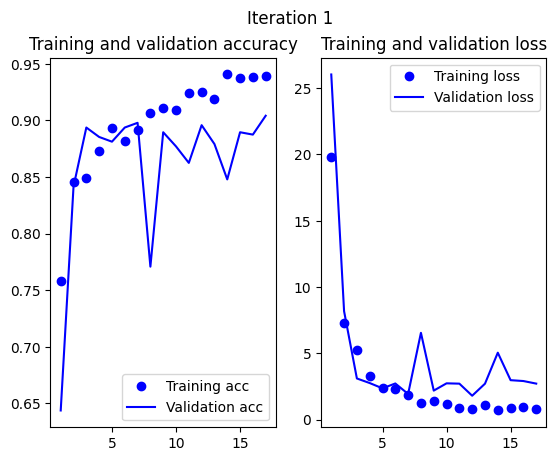

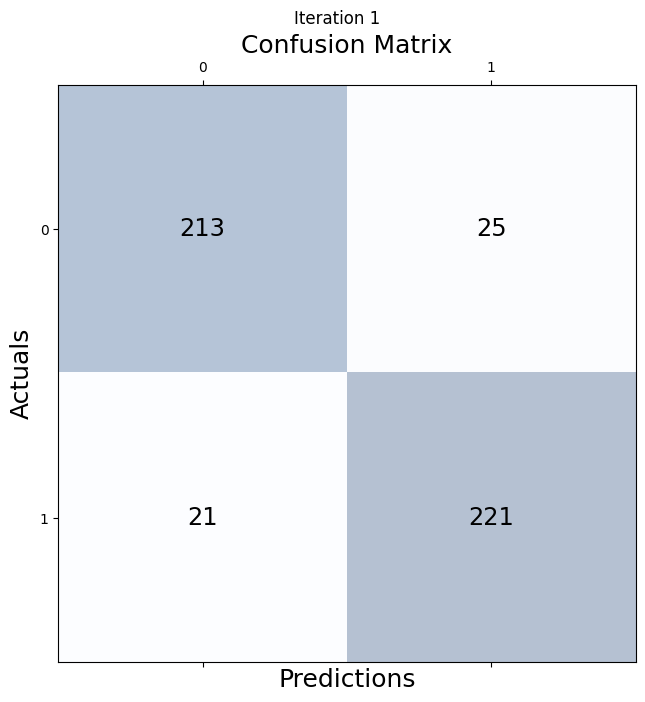

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 2:
Training   -> acc of 0.9098958373069763;  loss of 0.9896976947784424;
Validation -> acc of 0.8999999761581421;  loss of 1.8429611921310425%



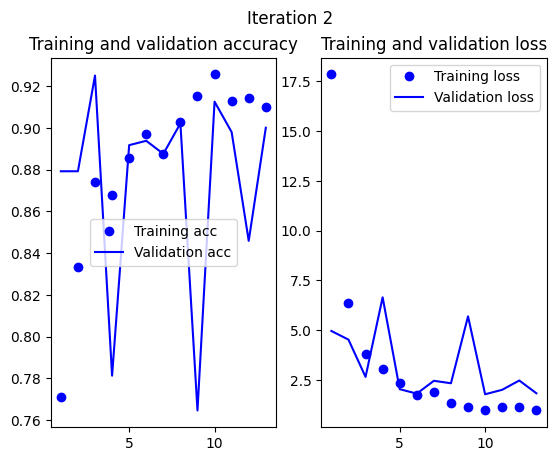

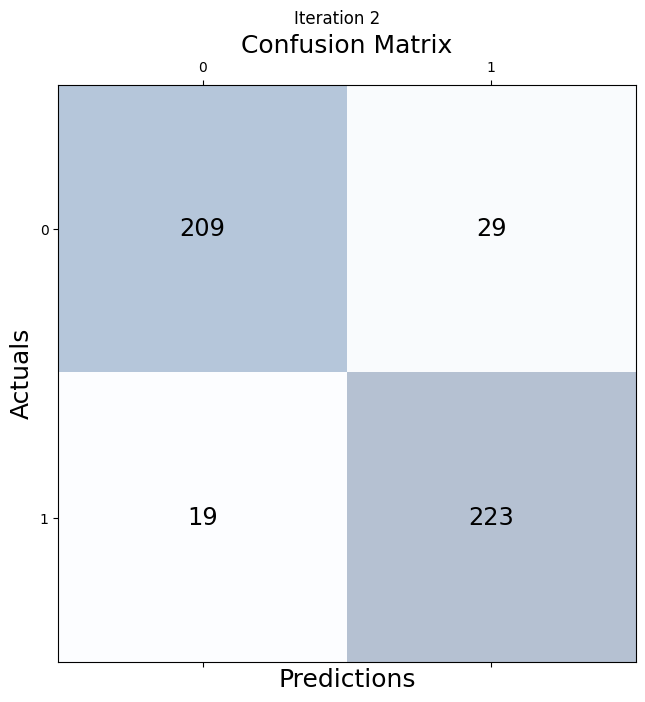

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 3:
Training   -> acc of 0.9234374761581421;  loss of 1.0926094055175781;
Validation -> acc of 0.8458333611488342;  loss of 3.5728490352630615%



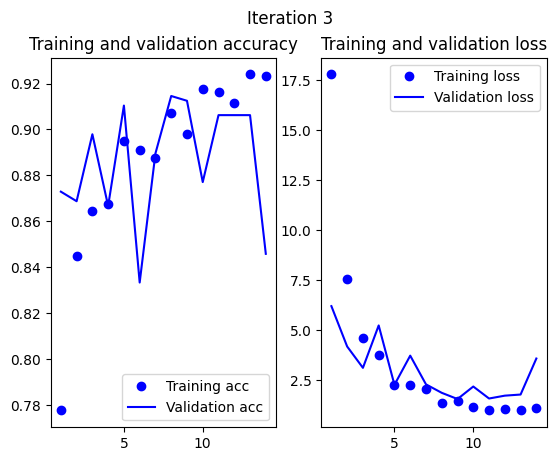

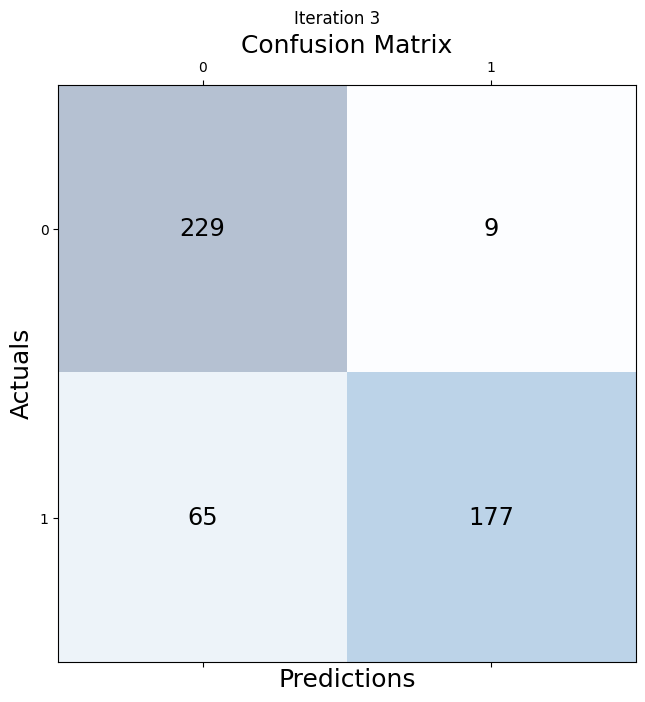

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 4:
Training   -> acc of 0.9401041865348816;  loss of 0.8339895606040955;
Validation -> acc of 0.9041666388511658;  loss of 1.8236991167068481%



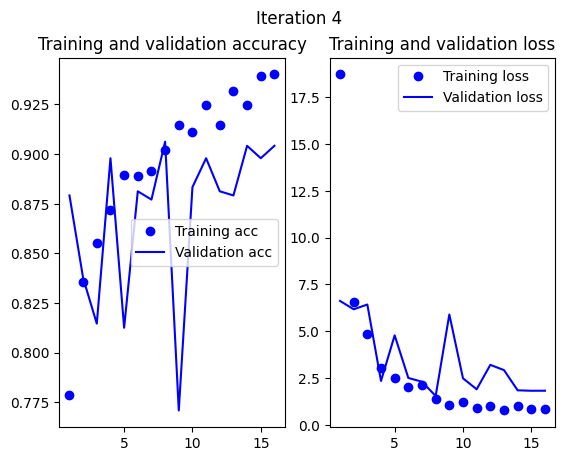

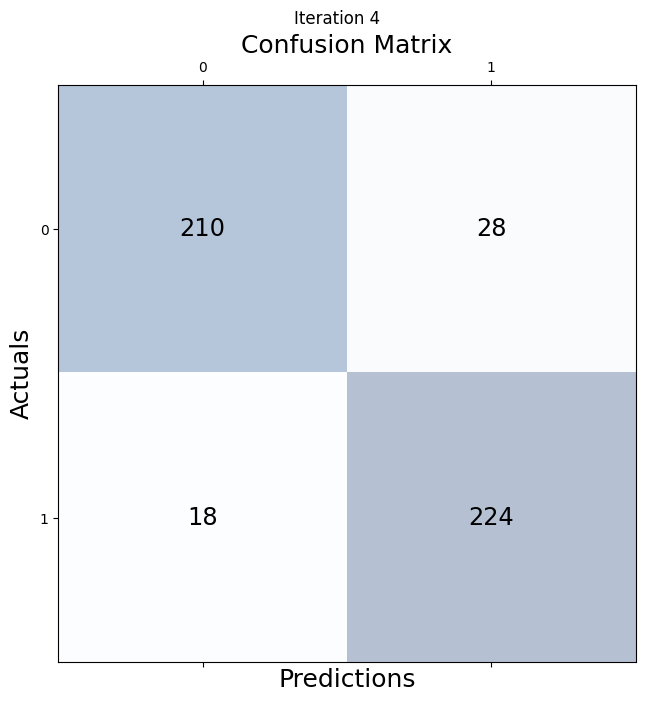

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 5:
Training   -> acc of 0.9442708492279053;  loss of 0.8675702810287476;
Validation -> acc of 0.9166666865348816;  loss of 2.5279922485351562%



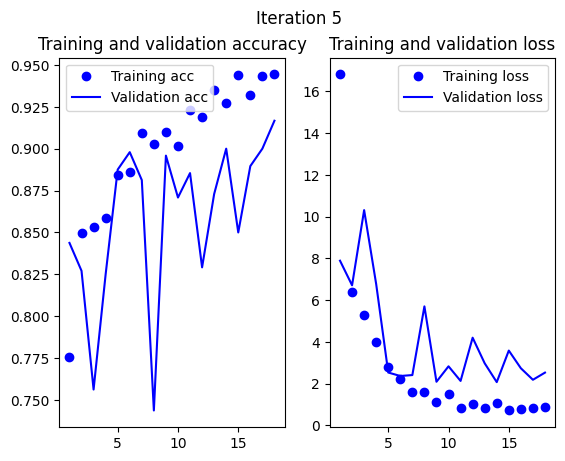

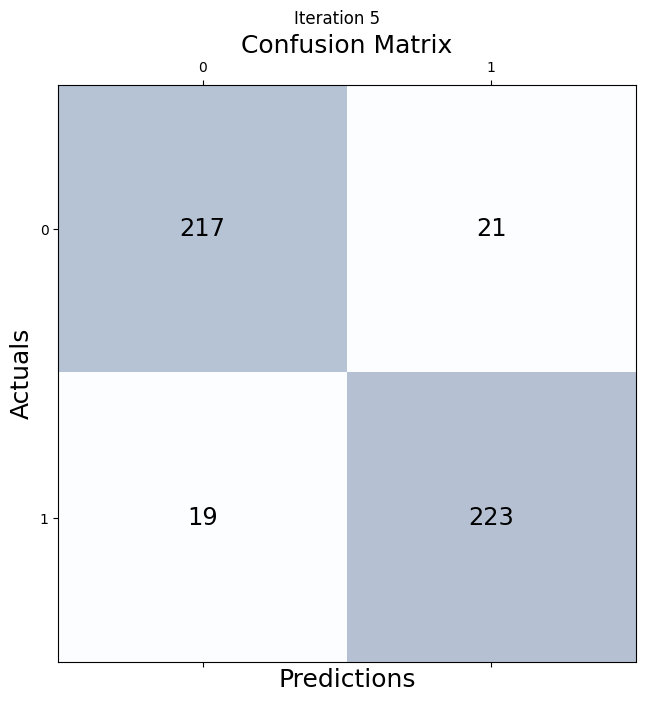

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 6:
Training   -> acc of 0.9432291388511658;  loss of 0.919422447681427;
Validation -> acc of 0.8770833611488342;  loss of 2.531059980392456%



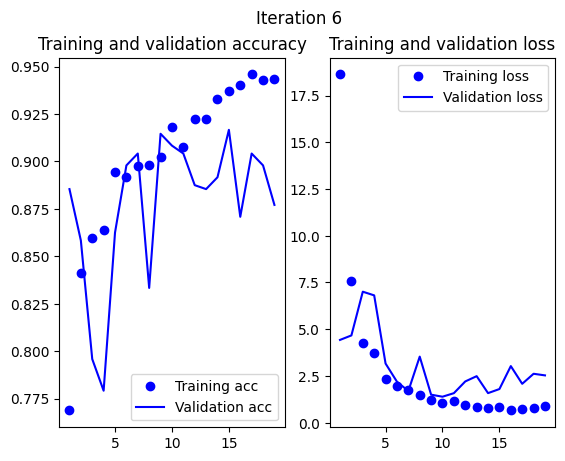

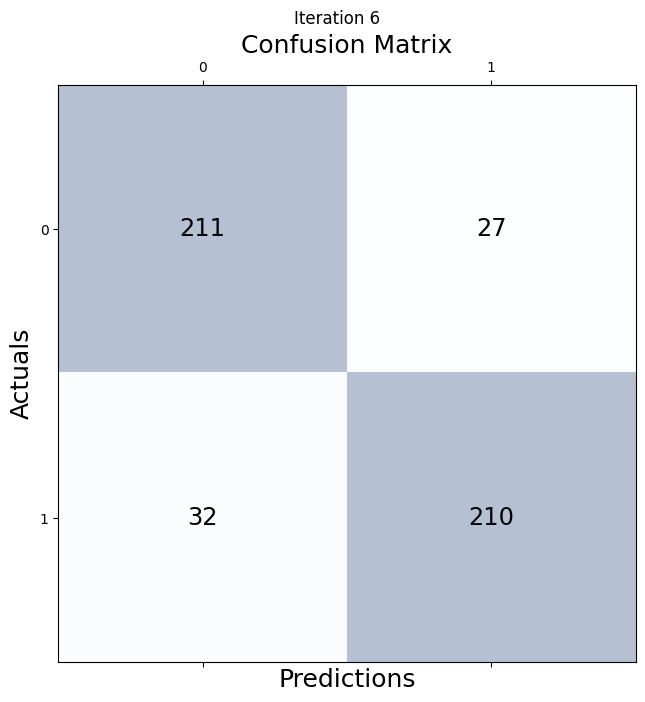

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 7:
Training   -> acc of 0.9526041746139526;  loss of 0.6714436411857605;
Validation -> acc of 0.8854166865348816;  loss of 3.0271761417388916%



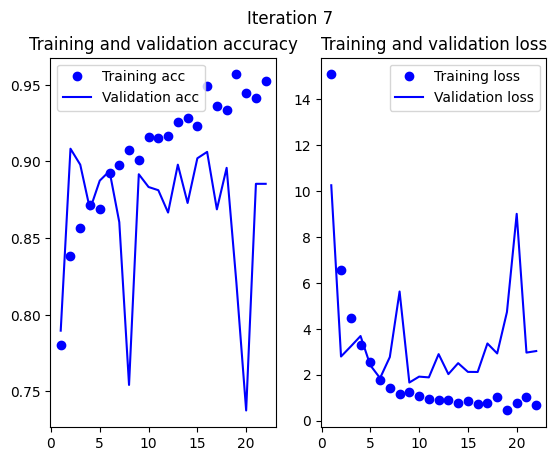

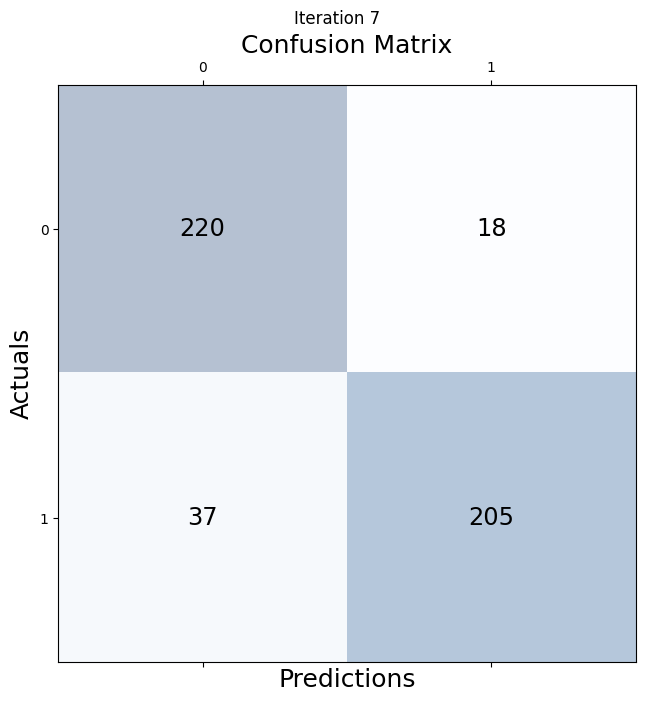

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 8:
Training   -> acc of 0.9432291388511658;  loss of 0.8706035017967224;
Validation -> acc of 0.8958333134651184;  loss of 2.444031000137329%



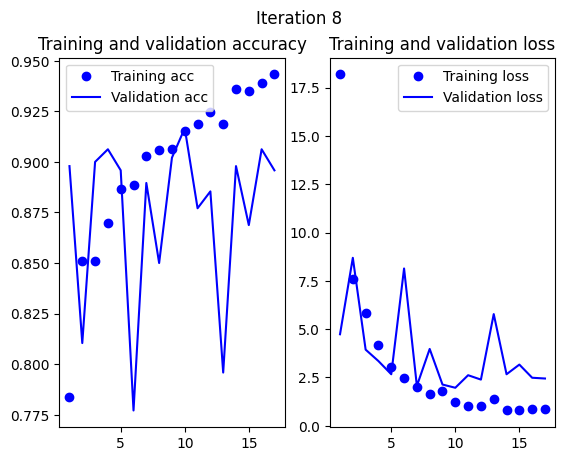

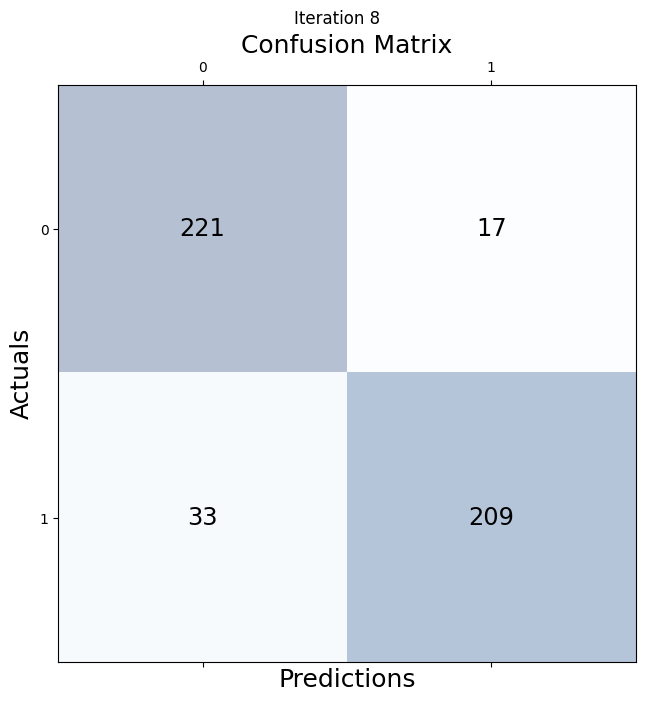

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 9:
Training   -> acc of 0.9427083134651184;  loss of 0.8886071443557739;
Validation -> acc of 0.8354166746139526;  loss of 5.16679048538208%



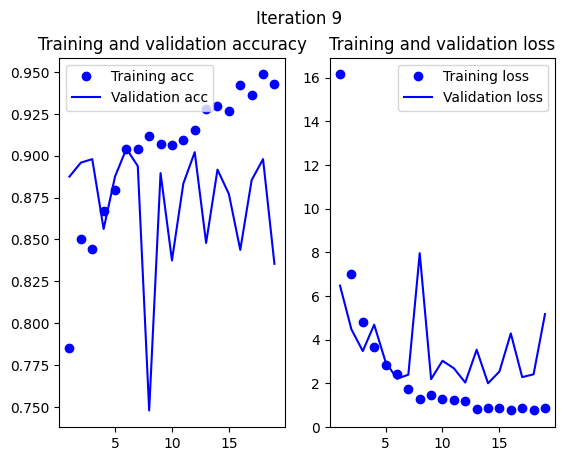

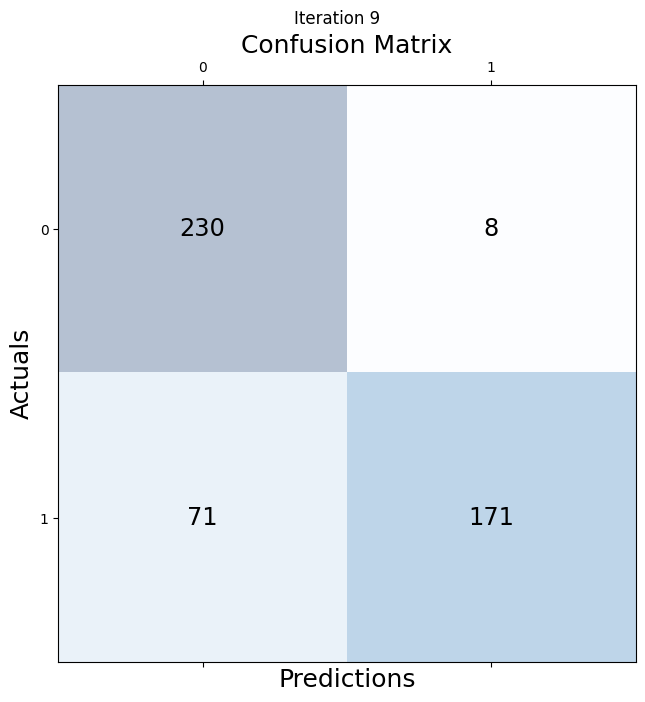

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 10:
Training   -> acc of 0.9416666626930237;  loss of 0.894814670085907;
Validation -> acc of 0.887499988079071;  loss of 2.1045684814453125%



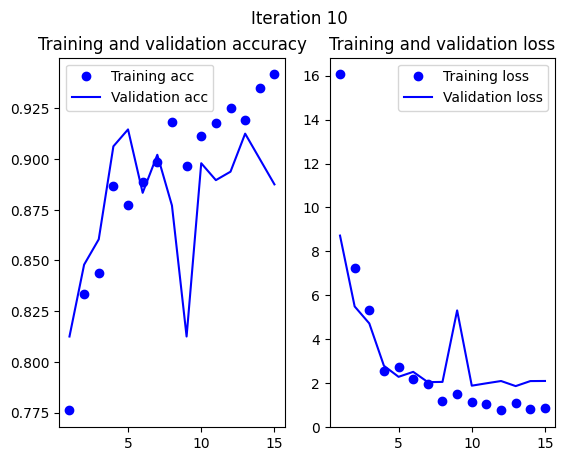

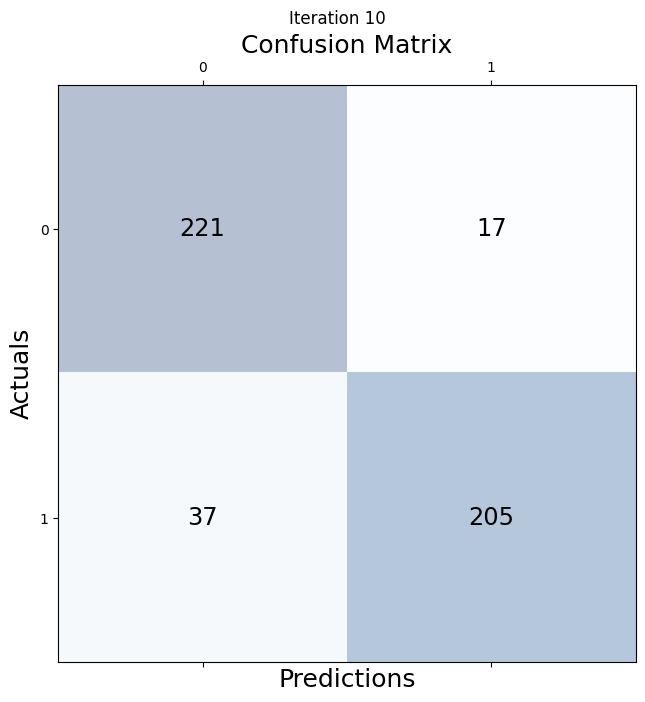

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 11:
Training   -> acc of 0.9437500238418579;  loss of 0.908539354801178;
Validation -> acc of 0.8479166626930237;  loss of 3.8402838706970215%



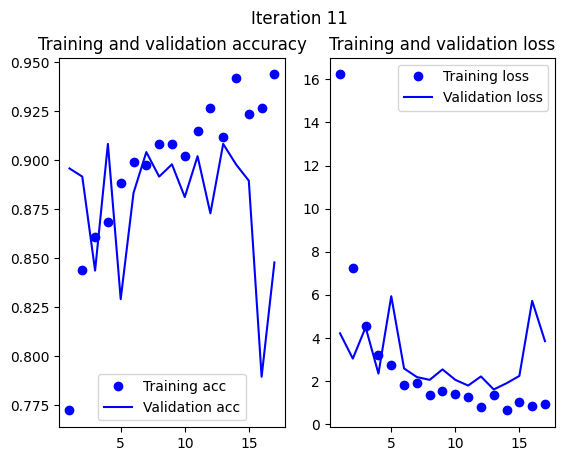

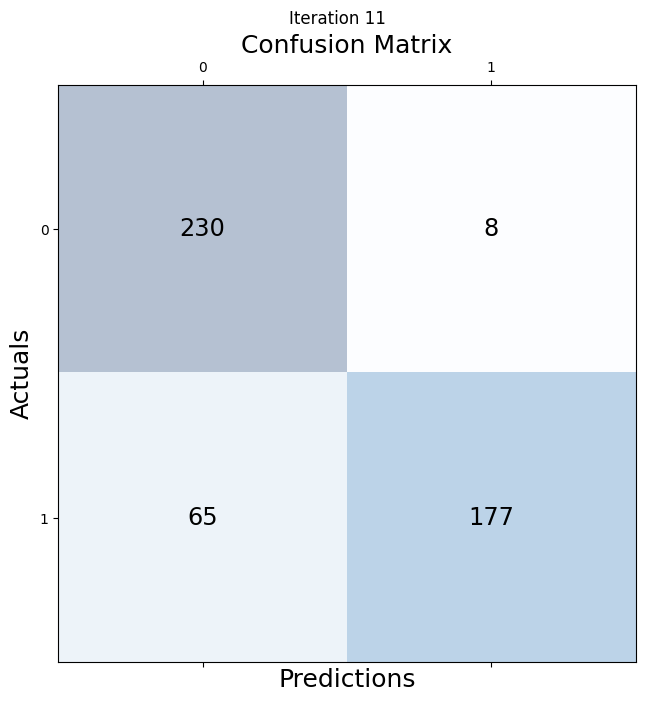

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 12:
Training   -> acc of 0.9479166865348816;  loss of 0.936718761920929;
Validation -> acc of 0.8229166865348816;  loss of 7.554461479187012%



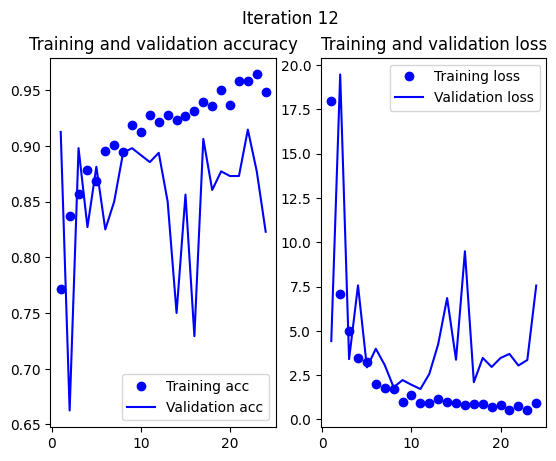

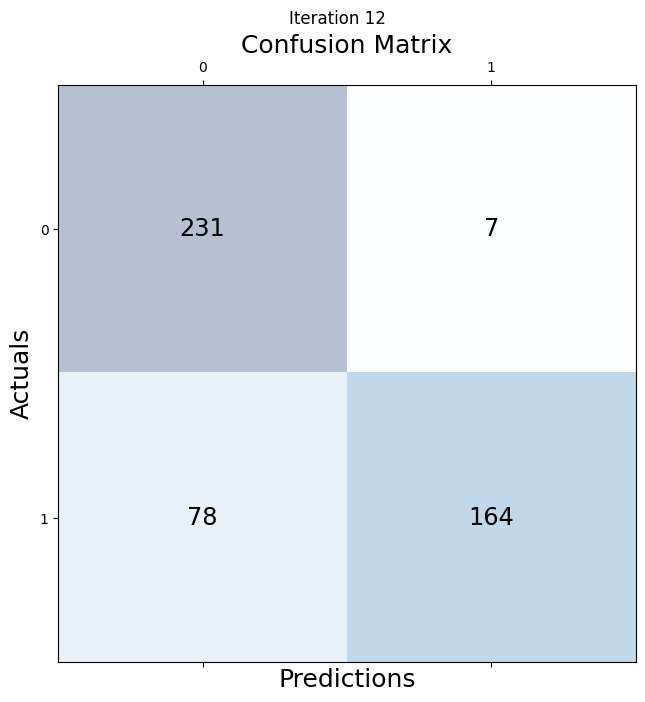

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 13:
Training   -> acc of 0.942187488079071;  loss of 0.9094749689102173;
Validation -> acc of 0.8791666626930237;  loss of 2.6454977989196777%



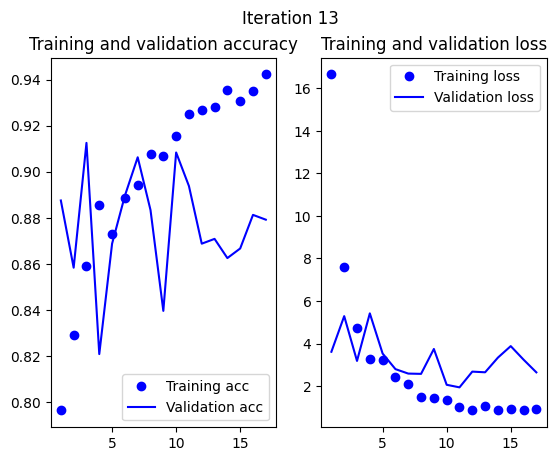

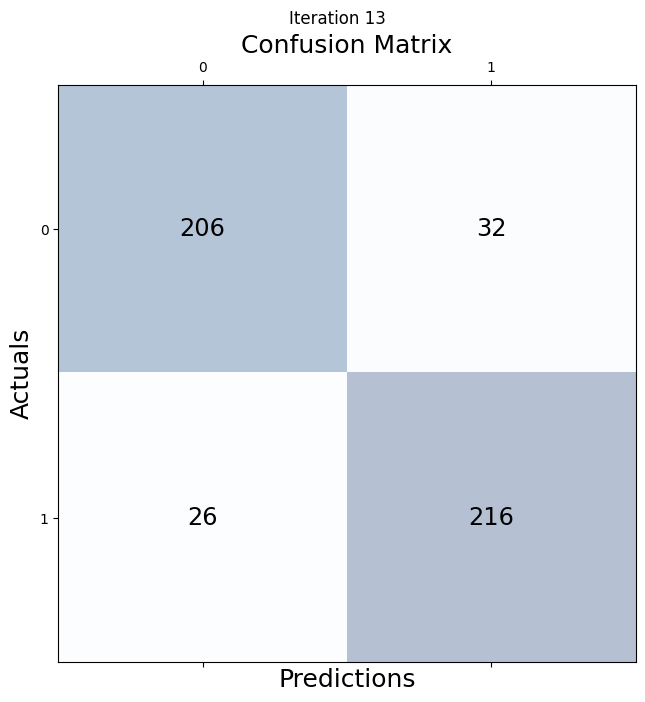

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 14:
Training   -> acc of 0.9661458134651184;  loss of 0.588061511516571;
Validation -> acc of 0.893750011920929;  loss of 3.2403745651245117%



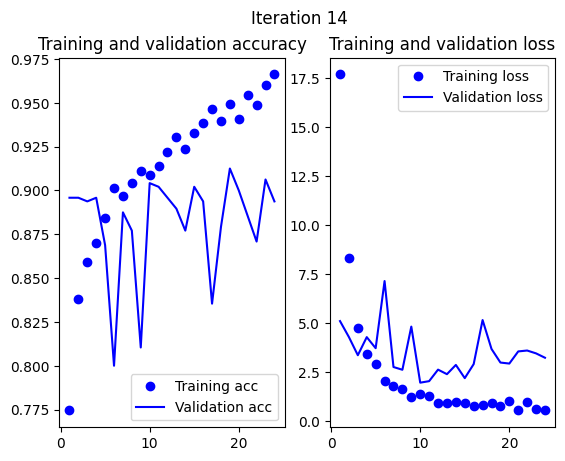

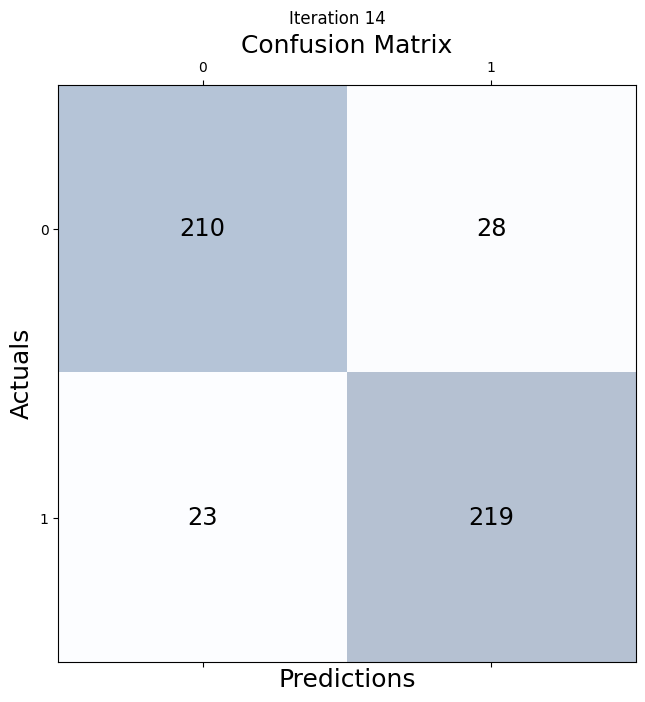

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 15:
Training   -> acc of 0.957812488079071;  loss of 0.6175326704978943;
Validation -> acc of 0.8916666507720947;  loss of 4.492553234100342%



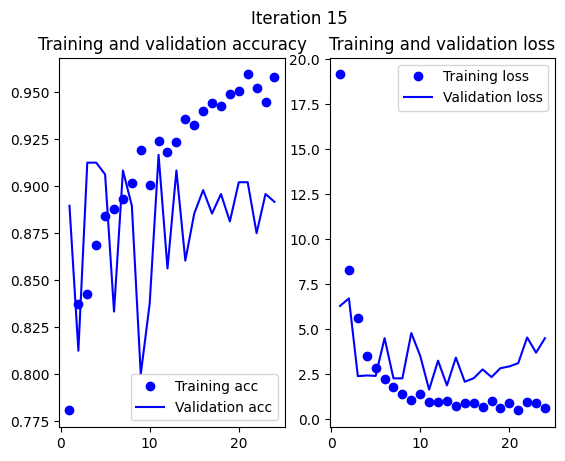

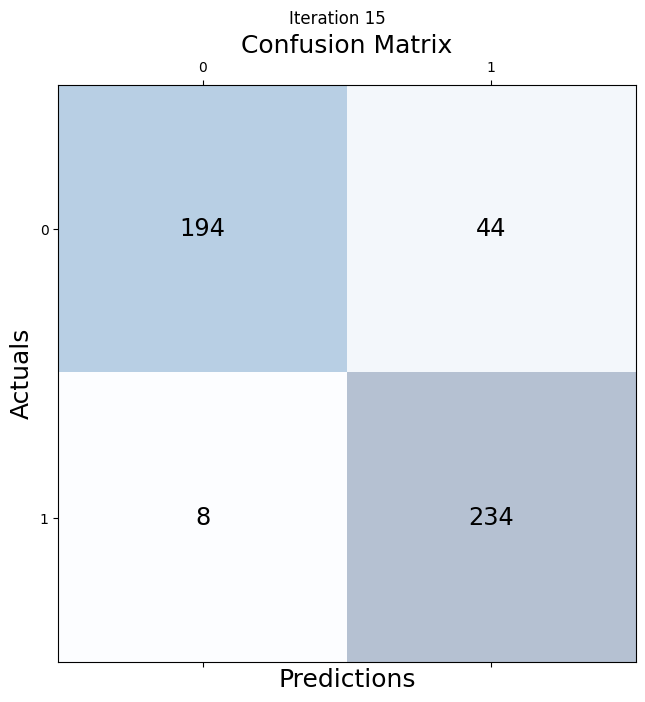

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 16:
Training   -> acc of 0.9333333373069763;  loss of 0.939410388469696;
Validation -> acc of 0.8166666626930237;  loss of 4.766260147094727%



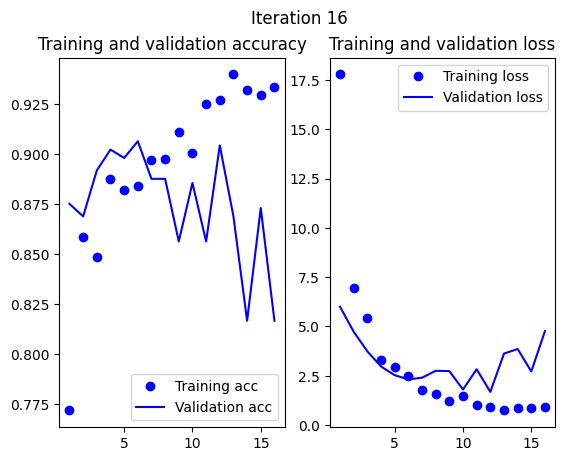

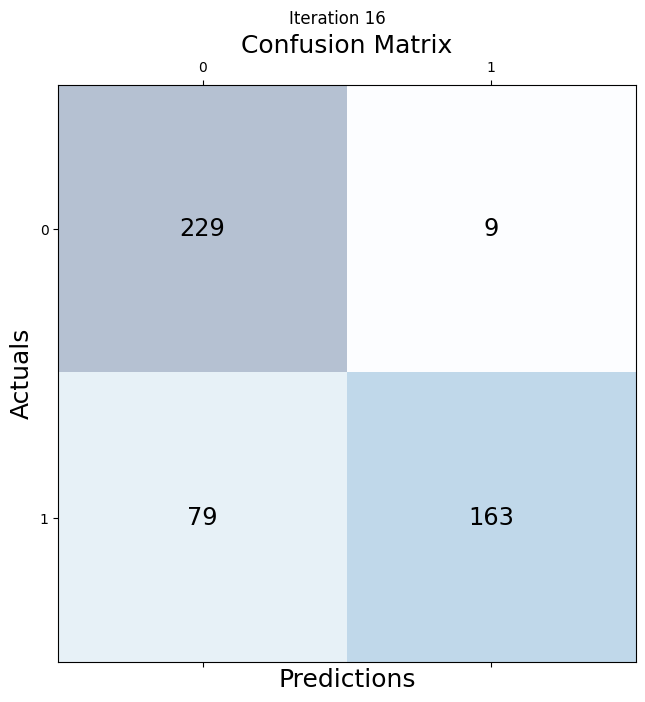

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 17:
Training   -> acc of 0.9520833492279053;  loss of 0.7090334296226501;
Validation -> acc of 0.8999999761581421;  loss of 2.705073833465576%



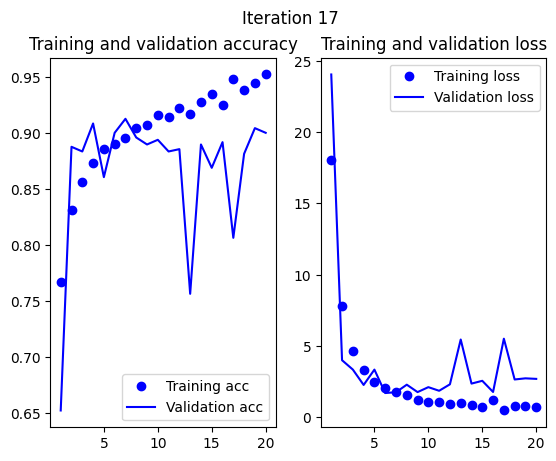

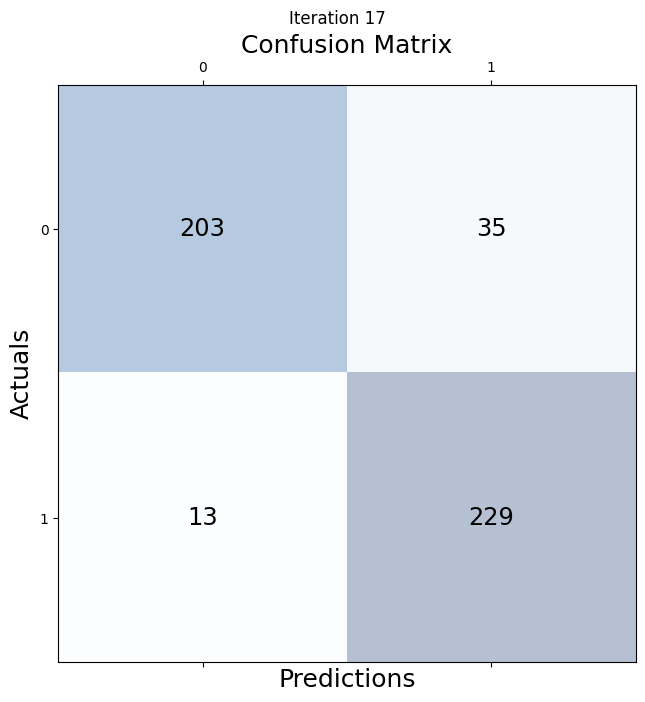

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 18:
Training   -> acc of 0.9354166388511658;  loss of 0.7705289721488953;
Validation -> acc of 0.8833333253860474;  loss of 2.6084868907928467%



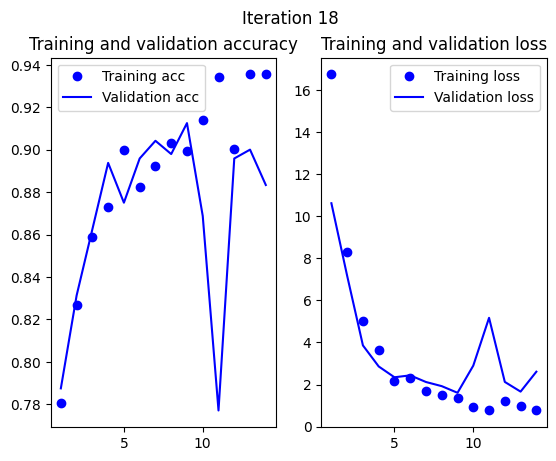

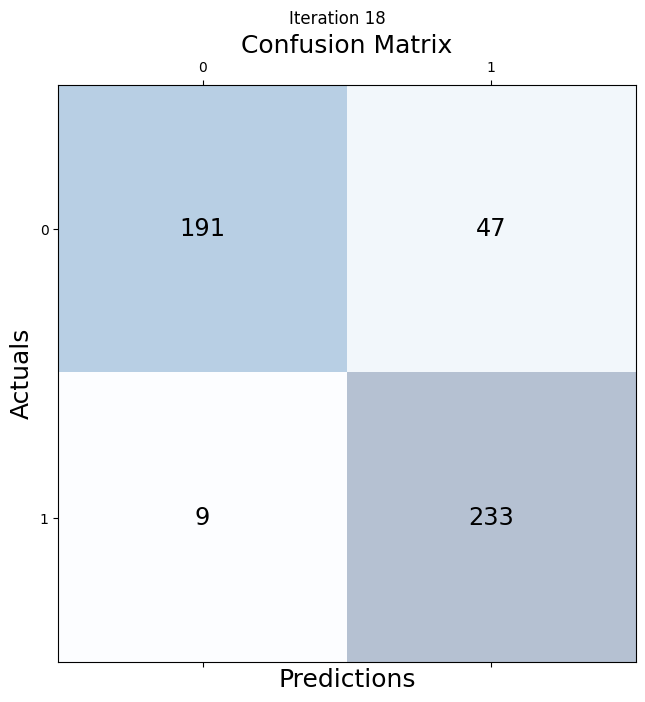

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 19:
Training   -> acc of 0.9552083611488342;  loss of 0.6985207200050354;
Validation -> acc of 0.8687499761581421;  loss of 5.401401042938232%



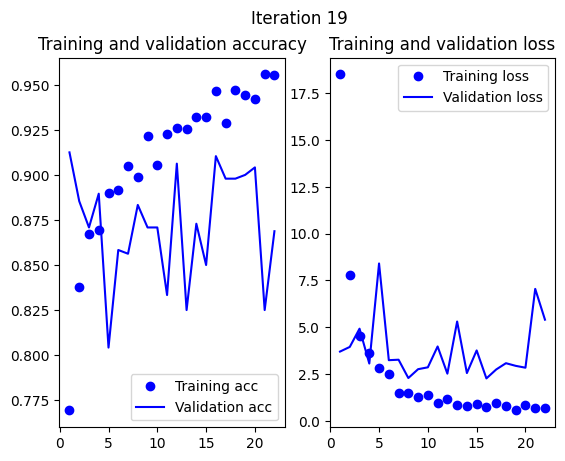

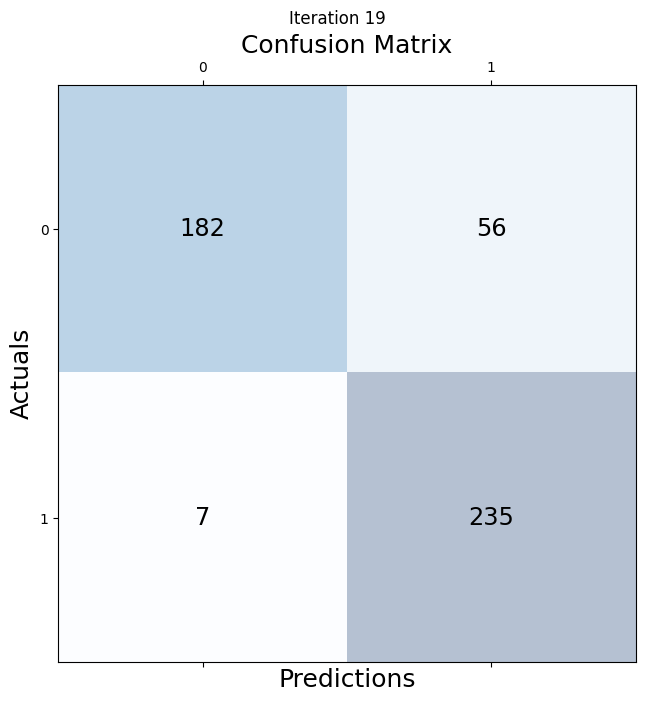

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 20:
Training   -> acc of 0.9359375238418579;  loss of 0.8941802382469177;
Validation -> acc of 0.8979166746139526;  loss of 2.113560199737549%



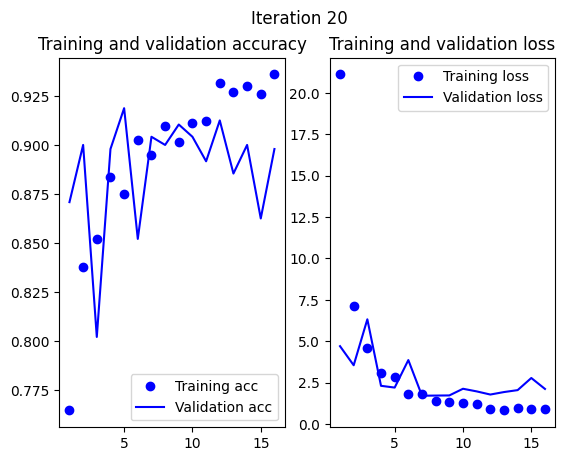

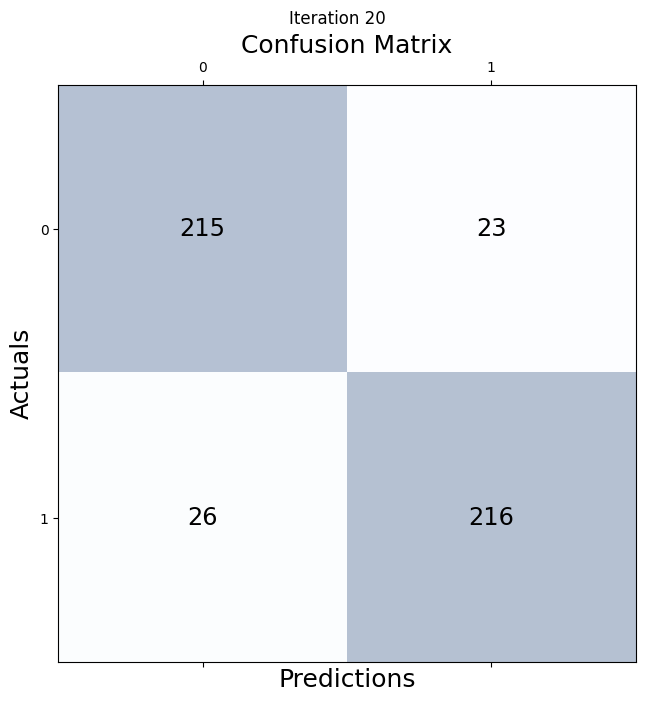

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 21:
Training   -> acc of 0.9442708492279053;  loss of 0.9452144503593445;
Validation -> acc of 0.9020833373069763;  loss of 2.9590351581573486%



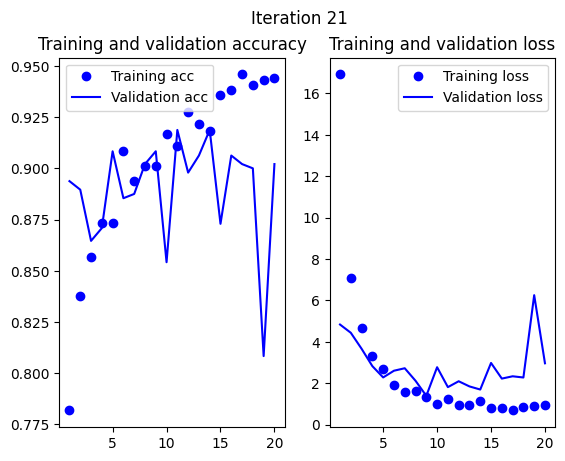

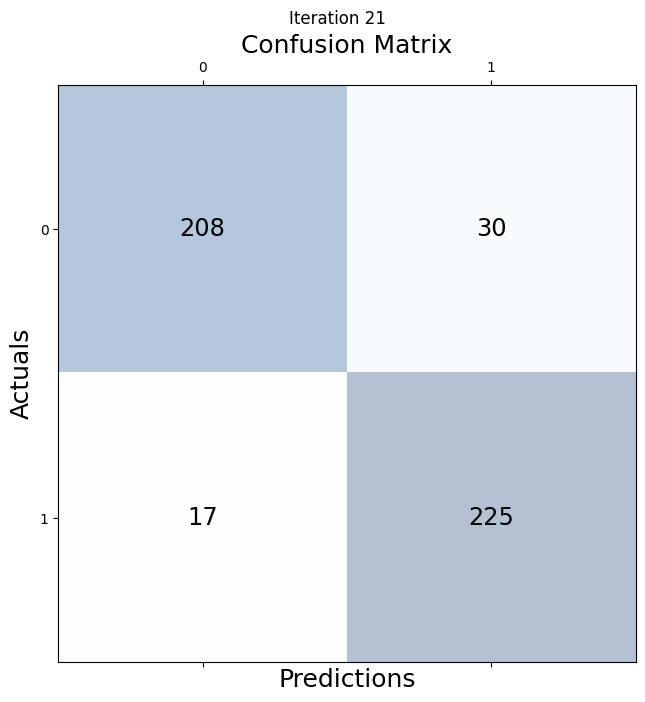

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 22:
Training   -> acc of 0.9515625238418579;  loss of 0.8083322048187256;
Validation -> acc of 0.8895833492279053;  loss of 3.021604061126709%



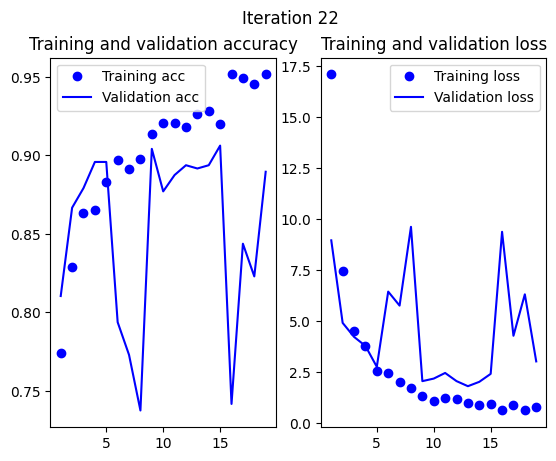

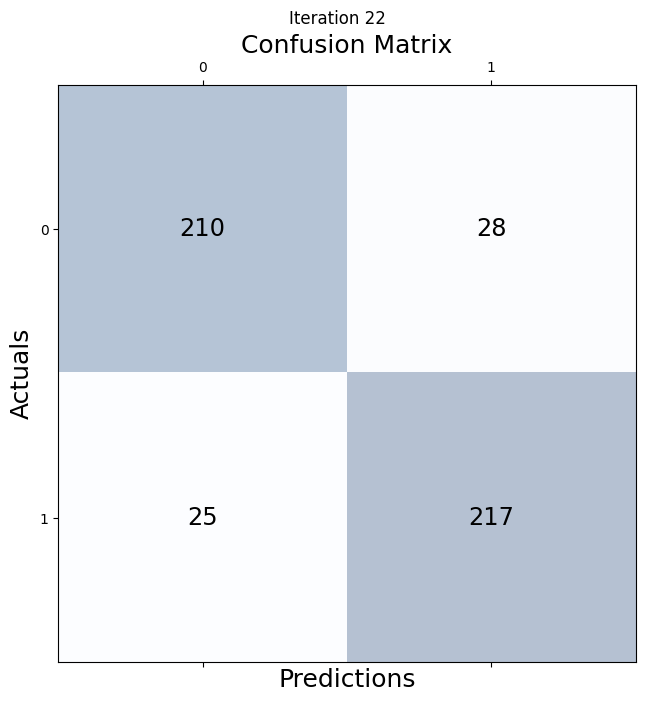

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 23:
Training   -> acc of 0.9442708492279053;  loss of 0.7361911535263062;
Validation -> acc of 0.8979166746139526;  loss of 2.2495462894439697%



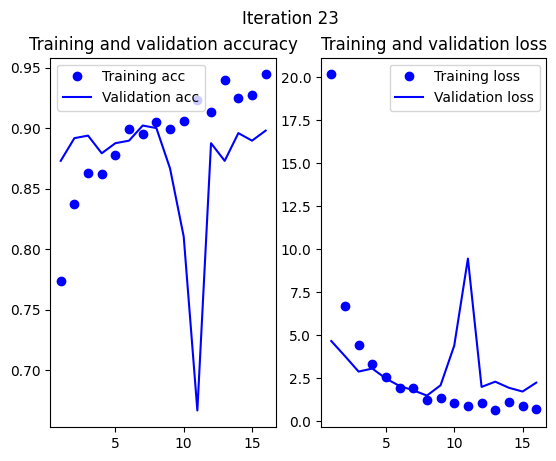

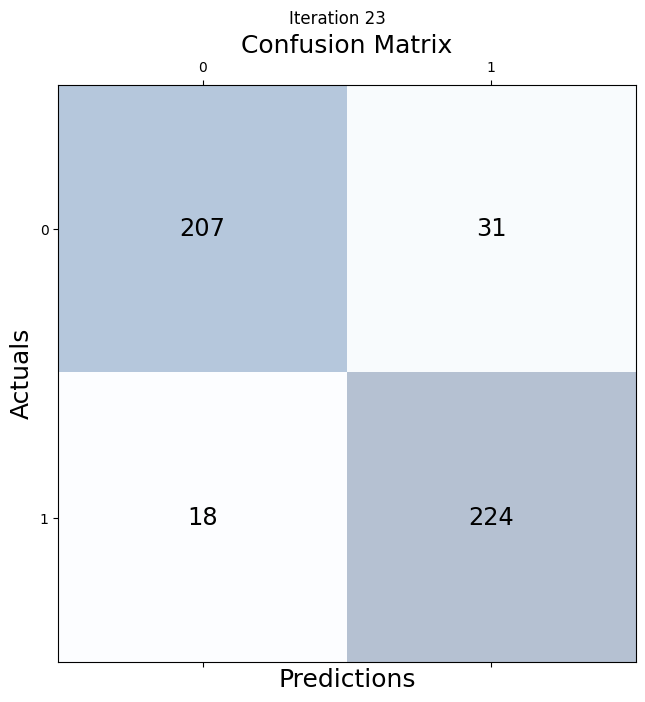

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 24:
Training   -> acc of 0.9526041746139526;  loss of 0.6943605542182922;
Validation -> acc of 0.9020833373069763;  loss of 3.411783456802368%



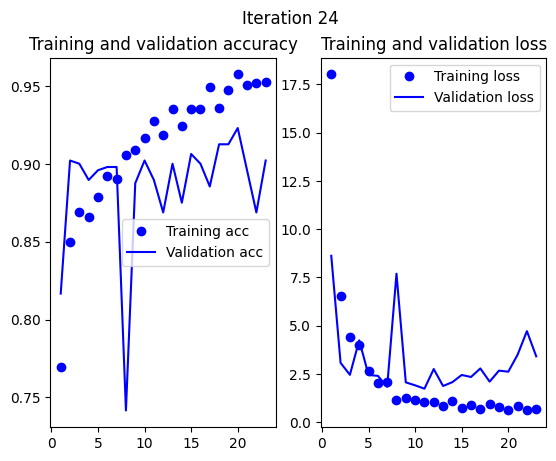

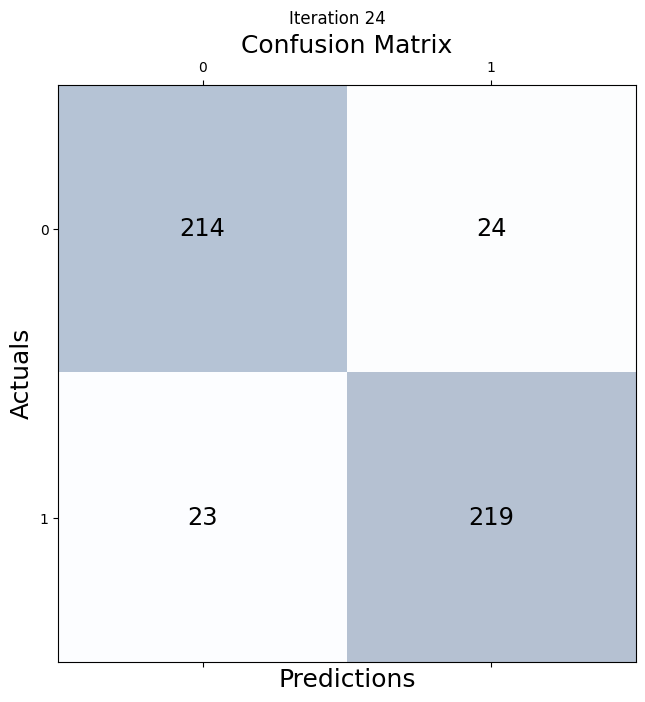

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 25:
Training   -> acc of 0.9489583373069763;  loss of 0.8000755310058594;
Validation -> acc of 0.9083333611488342;  loss of 3.528183937072754%



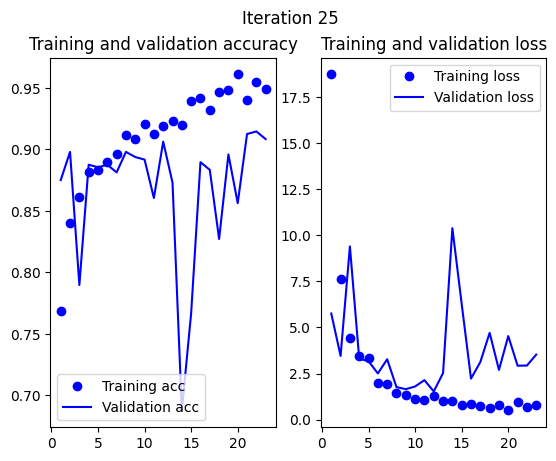

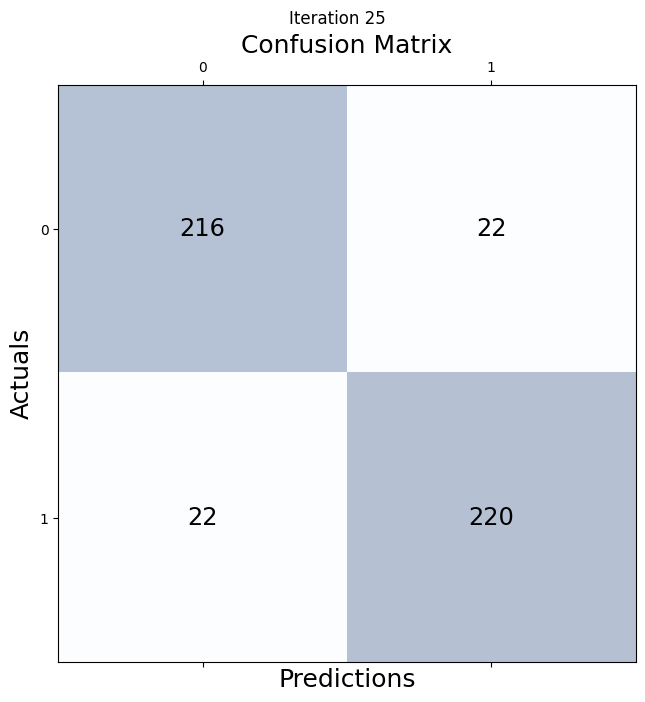

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 26:
Training   -> acc of 0.9567708373069763;  loss of 0.7134100794792175;
Validation -> acc of 0.8854166865348816;  loss of 3.5889134407043457%



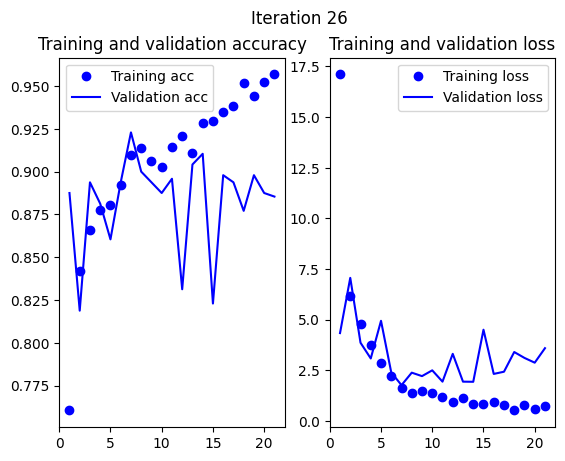

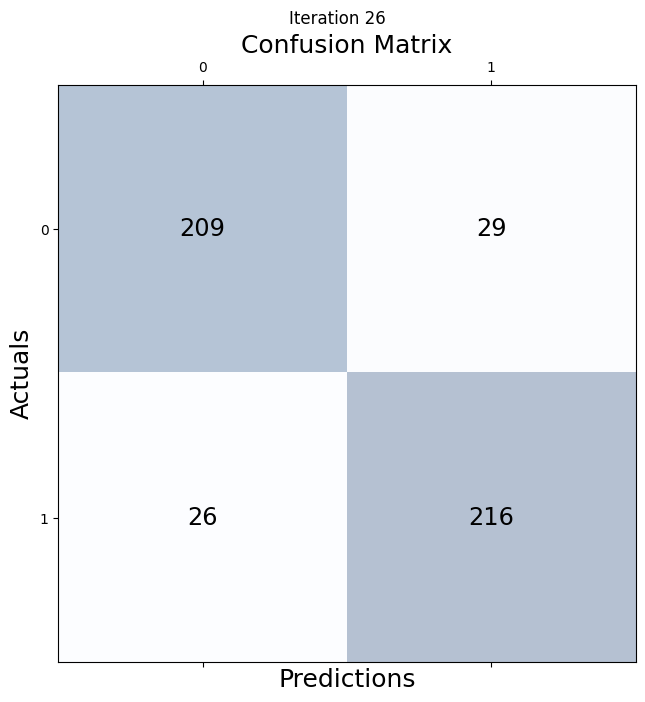

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 27:
Training   -> acc of 0.9427083134651184;  loss of 0.7184216380119324;
Validation -> acc of 0.9041666388511658;  loss of 3.0557870864868164%



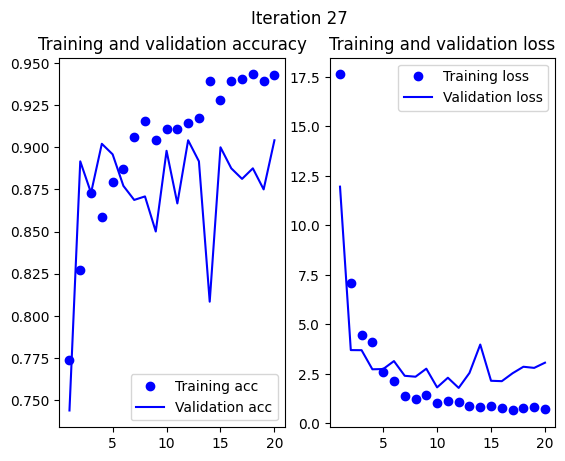

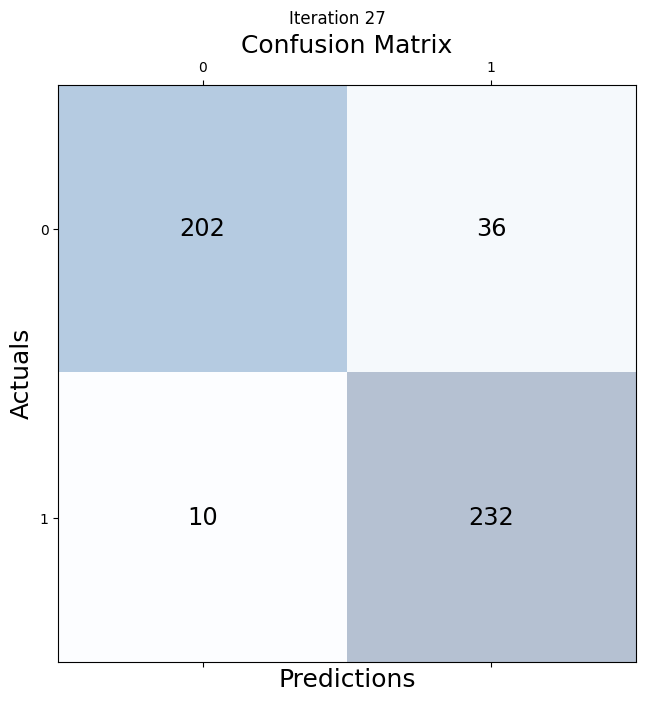

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 28:
Training   -> acc of 0.9380208253860474;  loss of 0.9538856744766235;
Validation -> acc of 0.8895833492279053;  loss of 2.094958782196045%



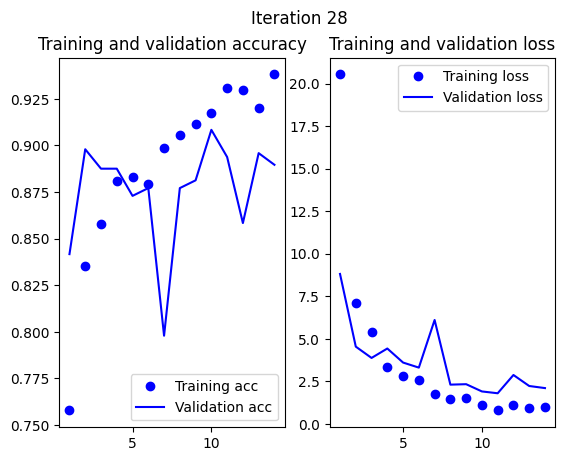

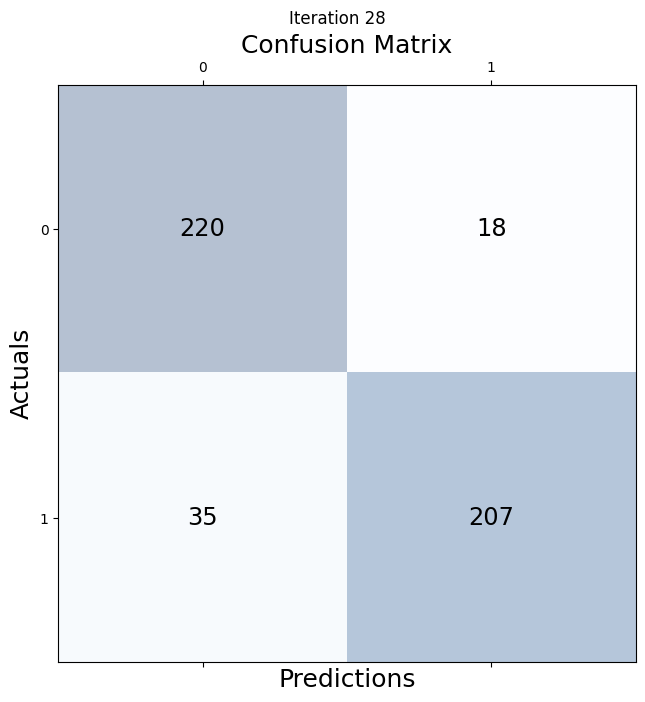

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 29:
Training   -> acc of 0.9510416388511658;  loss of 0.7854596376419067;
Validation -> acc of 0.8666666746139526;  loss of 3.9219257831573486%



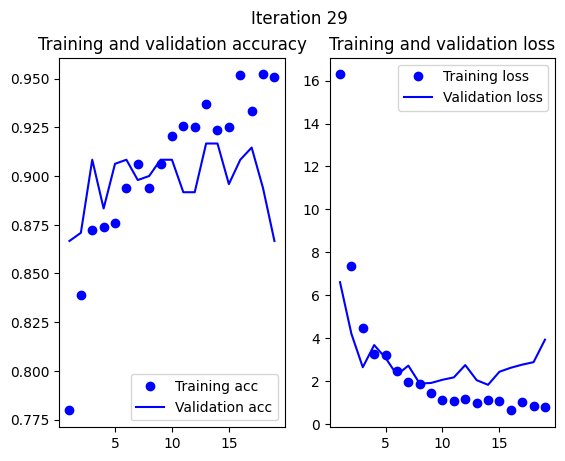

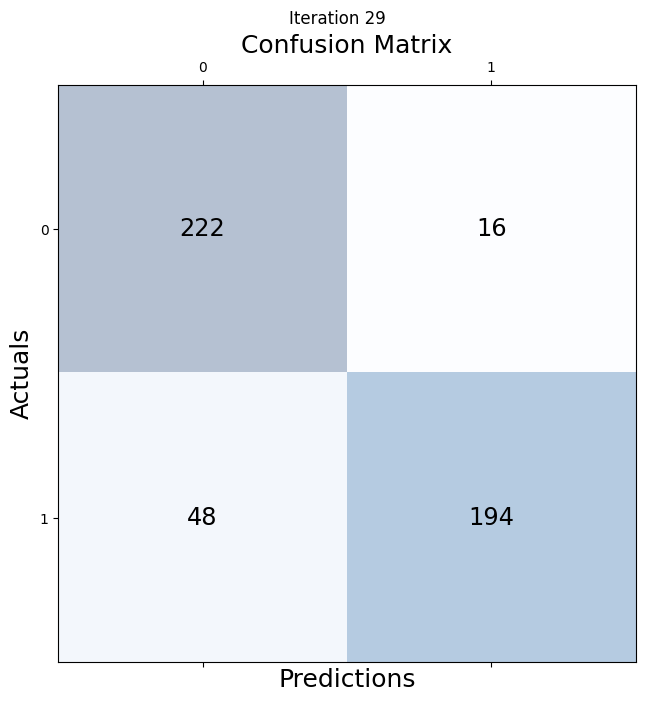

Found 2400 files belonging to 2 classes.
Using 1920 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 476 files belonging to 2 classes.
Score for iteration 30:
Training   -> acc of 0.9473958611488342;  loss of 0.97720867395401;
Validation -> acc of 0.9041666388511658;  loss of 3.5861902236938477%



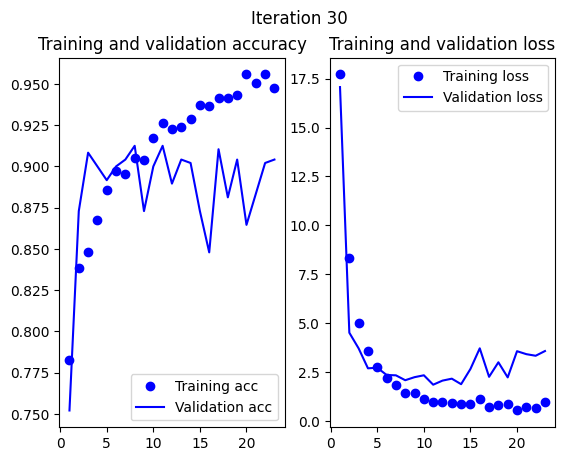

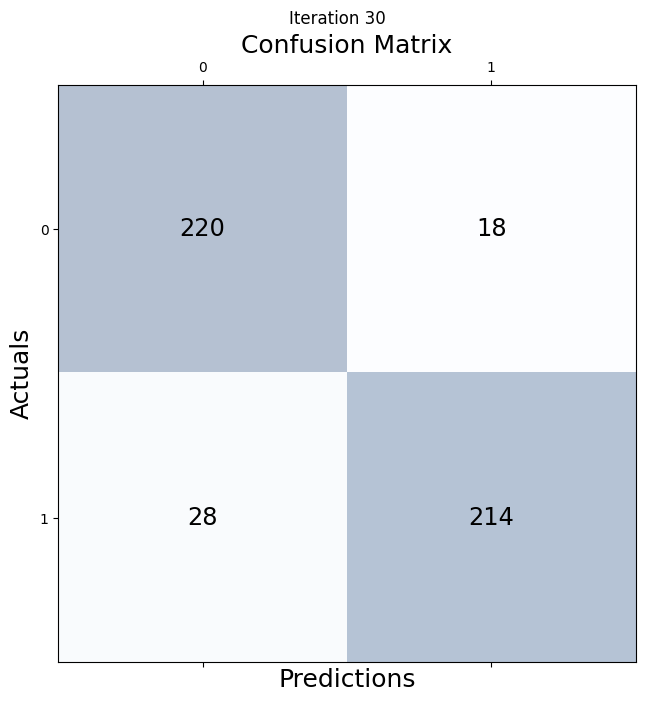

In [13]:
train_acc, train_loss, val_acc, val_loss = train_mccv(MCCV_iterations, epochs_nb)

# Results


Overall training accuracy: 94.42534724871318
Overall training loss: 0.8308115979035695

Overall validation ACCURACY: 88.34722220897675
- Mean:  88.34722220897675
- Standard deviation:  2.5293030997556265
- Variance:  6.39737417043342
Overall validation LOSS: 3.2848200877507527
- Mean:  3.2848200877507527
- Standard deviation:  1.212370175620642
- Variance:  1.4698414427344264


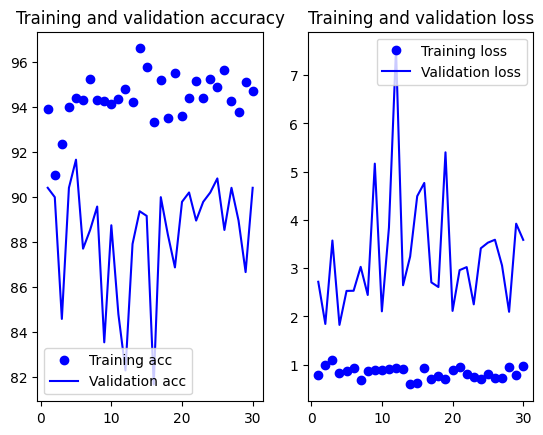

In [14]:
print("\nOverall training accuracy: " + str(np.average(train_acc)))
print("Overall training loss: " + str(np.average(train_loss)))
print("\nOverall validation ACCURACY: " + str(np.average(val_acc)))
r1 = np.mean(val_acc)
print("- Mean: ", r1)  
r2 = np.std(val_acc)
print("- Standard deviation: ", r2)  
r3 = np.var(val_acc)
print("- Variance: ", r3)
print("Overall validation LOSS: " + str(np.average(val_loss)))
r1 = np.mean(val_loss)
print("- Mean: ", r1)  
r2 = np.std(val_loss)
print("- Standard deviation: ", r2)  
r3 = np.var(val_loss)
print("- Variance: ", r3)
# Plot
iterations = range(1, MCCV_iterations + 1)

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(iterations, train_acc, 'bo', label='Training acc')
ax1.plot(iterations, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()

ax2.plot(iterations, train_loss, 'bo', label='Training loss')
ax2.plot(iterations, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()